In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold

# Functions from the main experiments
from main import classifiers
from main import score_types
from data_wrappers.datasets import Data
from calib.utils.calibration import cv_calibration
from calib.utils.functions import get_sets

# Functions for the synthetic data
from probability_distributions import Dirichlet
from probability_distributions import MixtureDistribution

# Plots on barycentric choordinates
from barycentric import draw_tri_samples
from barycentric import draw_pdf_contours
from barycentric import draw_func_contours
from barycentric import plot_individual_pdfs
from barycentric import plot_marginal
from barycentric import get_mesh_bc
from barycentric import plot_converging_lines_pvalues
from barycentric import get_converging_lines

# For barycentric grid size (higher values are computationally more expensive)
nlevels=100
subdiv=6

# For all random number generators
seed = 42

/home/maikel/git/uob/dirichlet_cal_experiments/venv/lib/python3.4/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
../calib/utils/plots.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_g

In [2]:
%%html
<!-- This is only to avoid the scroll on outputs with several figures -->
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:9000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Calibration methods to compare

In [3]:
methods = [None, 'beta', 'isotonic', 'dirichlet_full',
           'dirichlet_diag', 'dirichlet_fix_diag',
           #'dirichlet_mixture'
          ]

# Synthetic Dirichlet distribution

In [4]:
class_dist = MixtureDistribution([0.33, 0.33, 0.34], 
                                  (Dirichlet([2, 1, 1]),     
                                   Dirichlet([1, 5, 2]), 
                                   Dirichlet([3, 4, 10])))

print(class_dist)

prior = 0.33, Distribution = [2,1,1]
prior = 0.33, Distribution = [1,5,2]
prior = 0.34, Distribution = [ 3, 4,10]



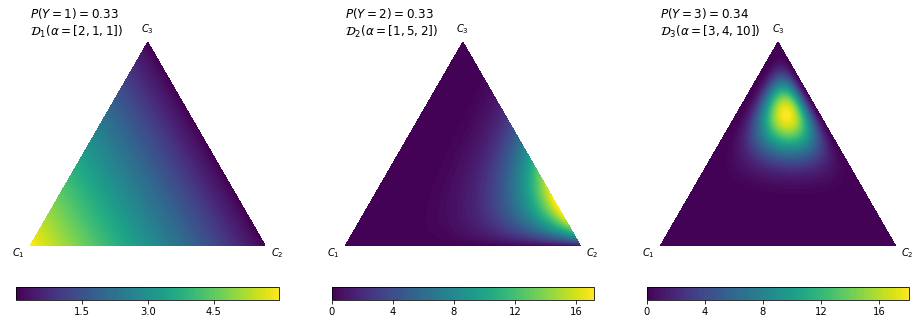

In [5]:
plot_individual_pdfs(class_dist, nlevels=nlevels, subdiv=subdiv)

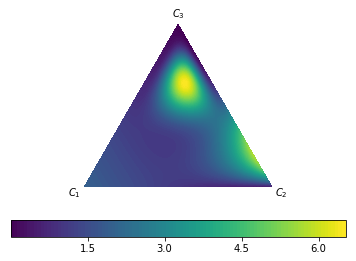

In [6]:
draw_pdf_contours(class_dist, labels='auto', nlevels=nlevels, subdiv=subdiv)

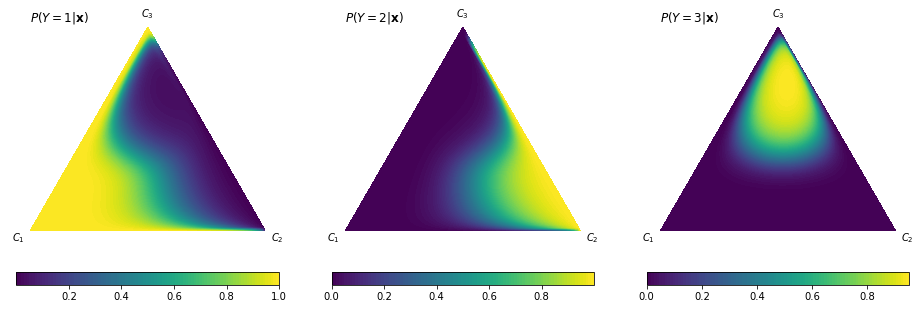

In [7]:
fig = plt.figure(figsize=(16, 5))
for i in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1), loc='left')
    
    class_dist.pdf = lambda x: class_dist.posterior(x, i)
    draw_pdf_contours(class_dist, labels='auto', fig=fig, ax=ax, nlevels=nlevels, subdiv=subdiv)

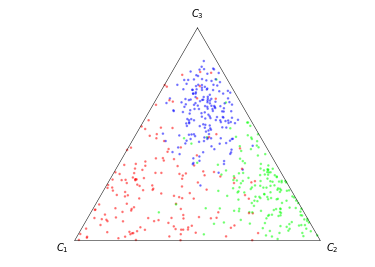

In [8]:
N = 500
scores, classes = class_dist.sample(N)

draw_tri_samples(scores, classes, s=10, marker='.', alpha=0.4)

# Test different calibration methods

- We will use as a initial classifier a mock class that only outputs the given input

In [9]:
classifier_name = 'mock'

classifier = classifiers[classifier_name]
score_type = score_types[classifier_name]
# TODO we should shuffle the datasets here
X = scores
Y = classes
y = Y.argmax(axis=1)
evaluation_folds = 2
calibration_folds = 2

skf = StratifiedKFold(y, n_folds=evaluation_folds, shuffle=True, random_state=seed)
test_folds = skf.test_folds
test_fold = 0

x_train, y_train, x_test, y_test = get_sets(X, y, test_fold, test_folds)   

In [10]:
accs, losses, briers, mean_probas, cl = cv_calibration(
    classifier, methods, x_train, y_train, x_test, y_test, 
    cv=calibration_folds, score_type=score_type, model_type='full-stack',
    verbose=0, seed=seed)

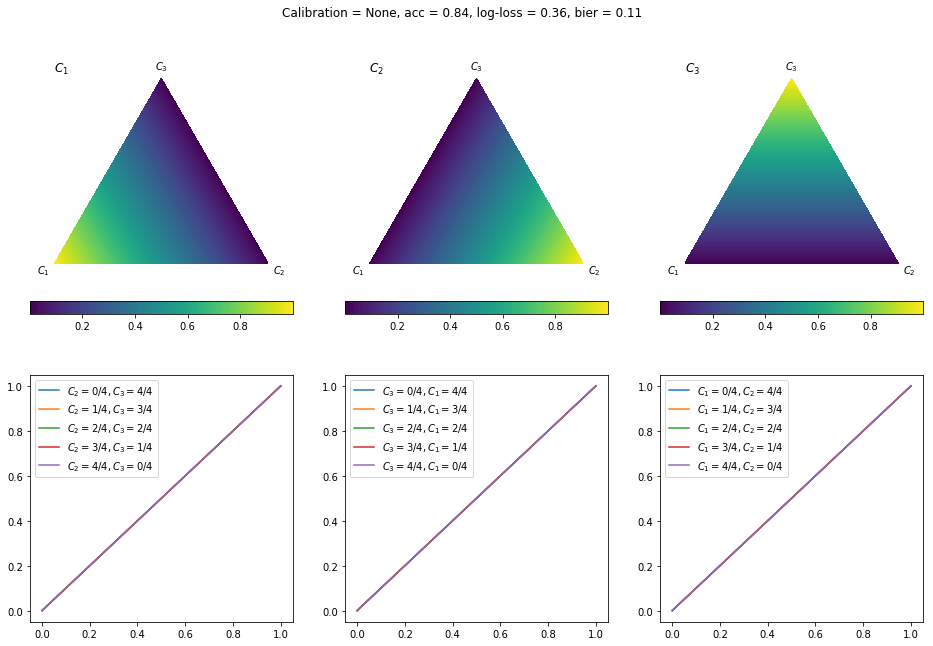

Calibrator _DummyCalibration()


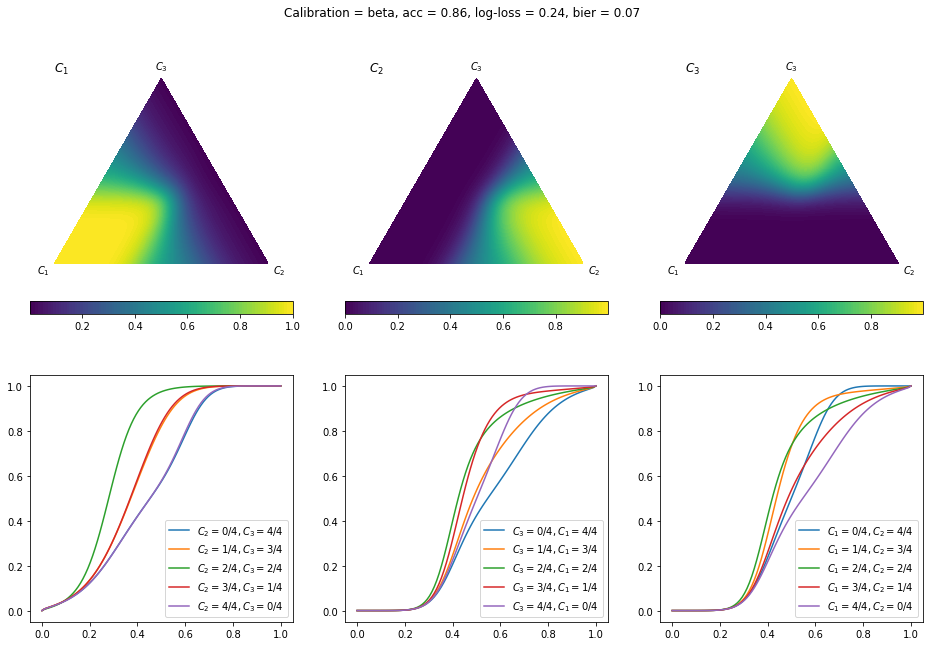

Calibrator OneVsRestCalibrator(estimator=BetaCalibration(parameters='abm'), n_jobs=1,
          normalize=False)


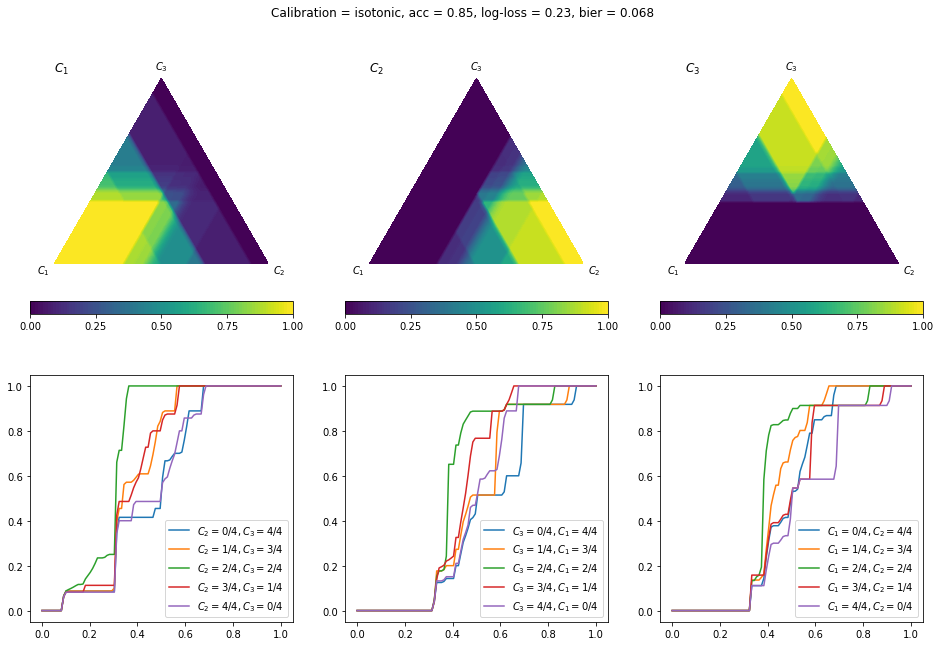

Calibrator OneVsRestCalibrator(estimator=IsotonicCalibration(increasing=True, out_of_bounds='clip', y_max=None,
          y_min=None),
          n_jobs=1, normalize=False)


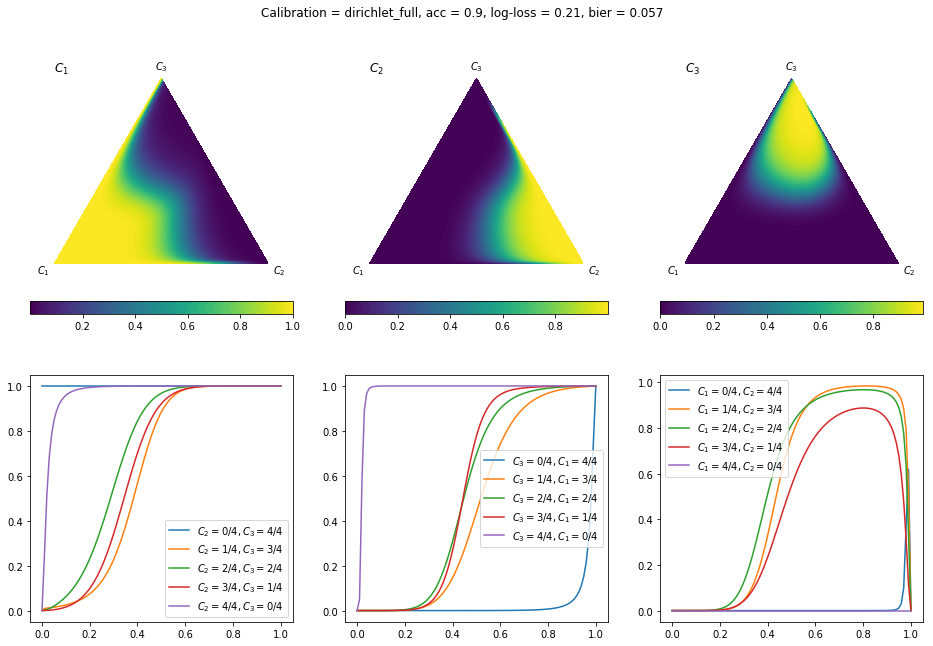

Calibrator DirichletCalibrator(matrix_type='full')
Coefficients are
[[ 0.         -1.9316064  -7.74980557]
 [-1.60436226  4.15327791 -7.01814008]]
Intercepts are
[-9.5842213  -5.66810815]


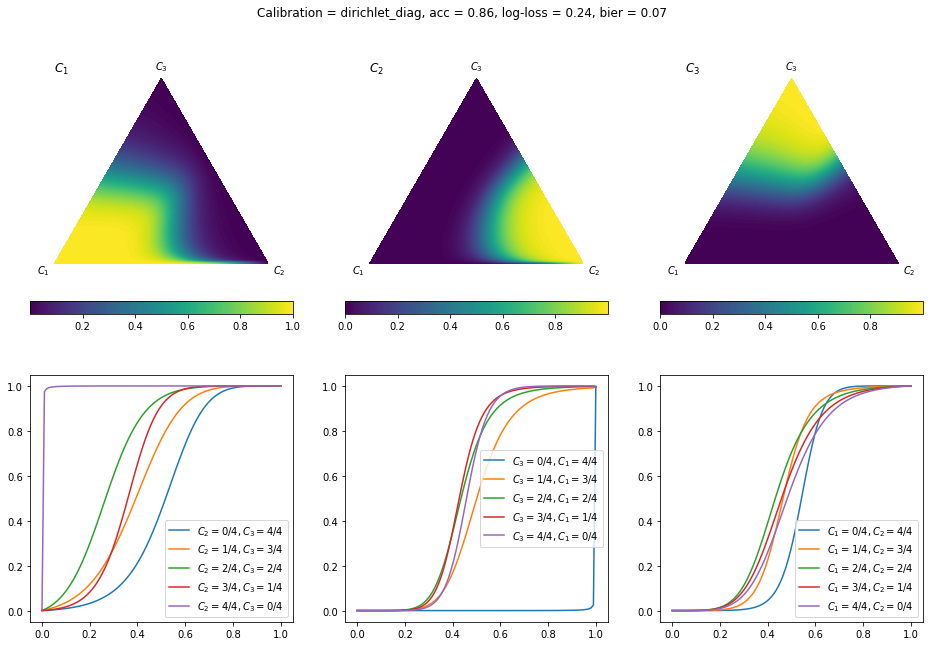

Calibrator DirichletCalibrator(matrix_type='diagonal')
Coefficients are
[[ 1.01784819  0.         -4.80176857]
 [ 0.          7.10828669 -3.76417709]]
Intercepts are
[-2.83240069  3.23753578]


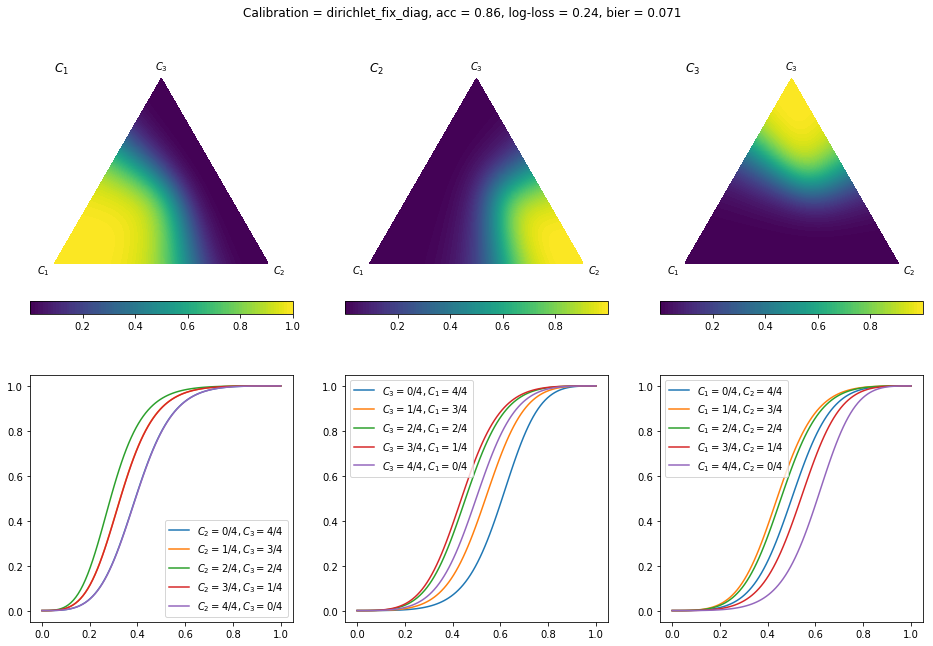

Calibrator DirichletCalibrator(matrix_type='fixed_diagonal')
Coefficients are
[[ 3.08792998  0.         -3.08792998]
 [ 0.          3.08792998 -3.08792998]]
Intercepts are
[1.36489168 0.01210268]


In [11]:
mesh = get_mesh_bc(subdiv=subdiv)

for method in methods:
    calibrator = cl[method][0].calibrator
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Calibration = {}, acc = {:.2}, log-loss = {:.2}, bier = {:.2}'.format(
        method, accs[method], losses[method], briers[method]))

    for i, c in enumerate(['C1', 'C2', 'C3']):
        ax = fig.add_subplot(2, 3, i+1)

        ax.set_title('$C_{}$'.format(i+1), loc='left')

        function = lambda x: calibrator.predict_proba(x.reshape(1,-1))[0][i]
        draw_func_contours(function, labels='auto', fig=fig, ax=ax, nlevels=nlevels, subdiv=subdiv)
        
        ax2 = fig.add_subplot(2, 3, 3+i+1)
    
        #function = lambda x: class_dist.posterior(x, i).reshape(-1,1)
        lines = get_converging_lines(num_lines=5, mesh_precision=nlevels, class_index=i)
        plot_converging_lines_pvalues(function, lines, i, ax2)
        
        #ax3 = fig.add_subplot(4, 3, 6+i+1)
        #ax4 = fig.add_subplot(4, 3, 9+i+1)
        #plot_marginal(function, mesh, c, ax3, ax4)
        
    plt.show()
    print('Calibrator {}'.format(calibrator))
    if hasattr(calibrator, 'coef_'):
        print('Coefficients are\n{}'.format(calibrator.coef_))
    if hasattr(calibrator, 'intercept_'):
        print('Intercepts are\n{}'.format(calibrator.intercept_))

# With a real dataset and a classifier

In [12]:
classifier_name = 'logistic'
classifier = classifiers[classifier_name]
score_type = score_types[classifier_name]
# TODO we should shuffle the datasets here
data = Data(dataset_names=['iris'])
dataset = data.datasets['iris']
evaluation_folds = 2
calibration_folds = 2

skf = StratifiedKFold(dataset.target, n_folds=evaluation_folds, shuffle=True, random_state=seed)
test_folds = skf.test_folds
test_fold = 0

x_train, y_train, x_test, y_test = get_sets(dataset.data, dataset.target, test_fold, test_folds)   

In [13]:
accs, losses, briers, mean_probas, cl = cv_calibration(
    classifier, methods, x_train, y_train, x_test, y_test, 
    cv=calibration_folds, score_type=score_type, model_type='full-stack',
    verbose=0, seed=seed)

# Draw test samples and classifier prediction

In [14]:
calibrator = cl[None][0]
scores = mean_probas[None]
classes = y_test

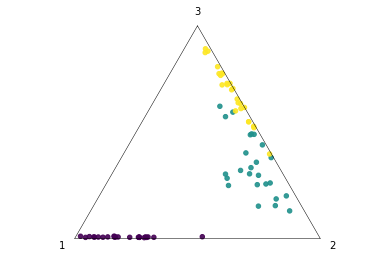

In [15]:
draw_tri_samples(scores, classes, labels=dataset.names, s=20, marker='o', alpha=0.9)

## Prediction space per Calibrator and class

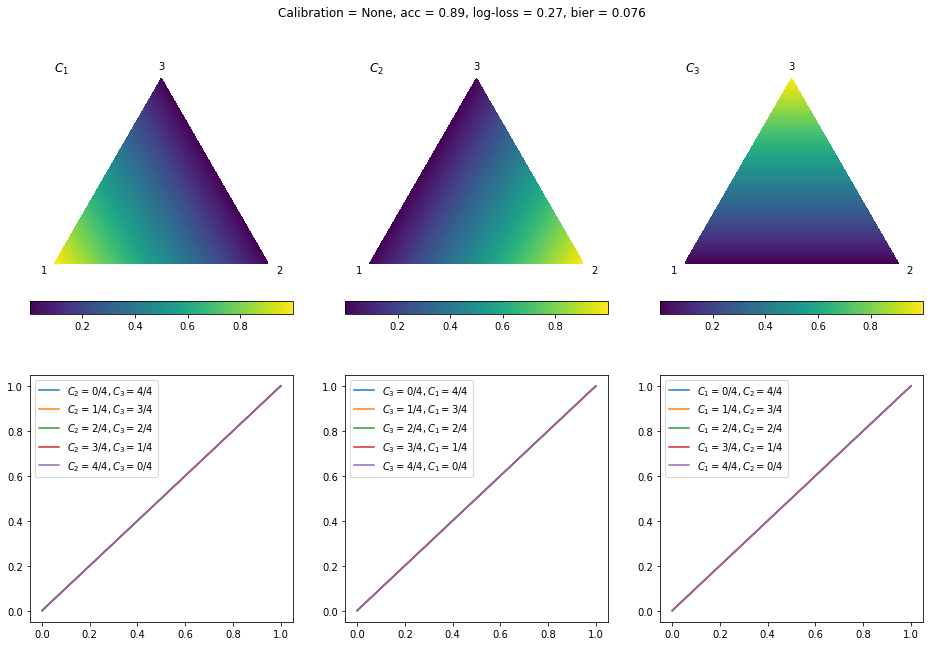

Calibrator _DummyCalibration()


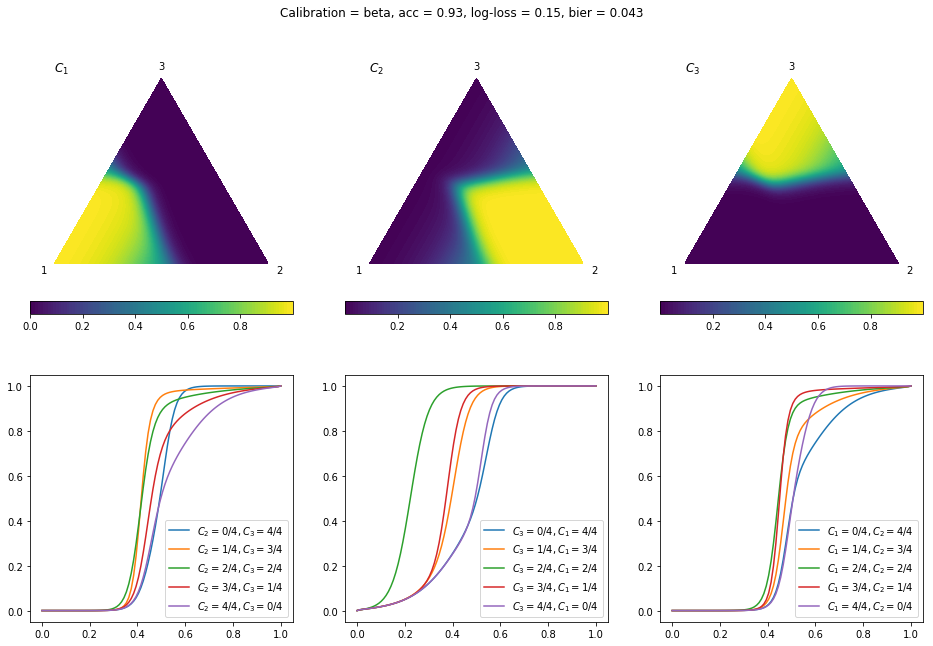

Calibrator OneVsRestCalibrator(estimator=BetaCalibration(parameters='abm'), n_jobs=1,
          normalize=False)


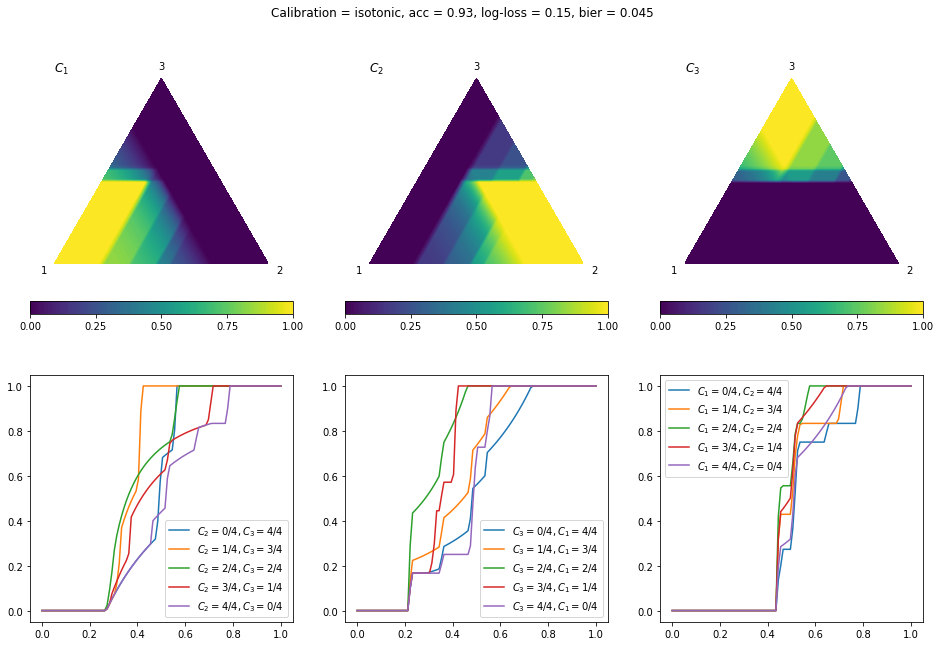

Calibrator OneVsRestCalibrator(estimator=IsotonicCalibration(increasing=True, out_of_bounds='clip', y_max=None,
          y_min=None),
          n_jobs=1, normalize=False)


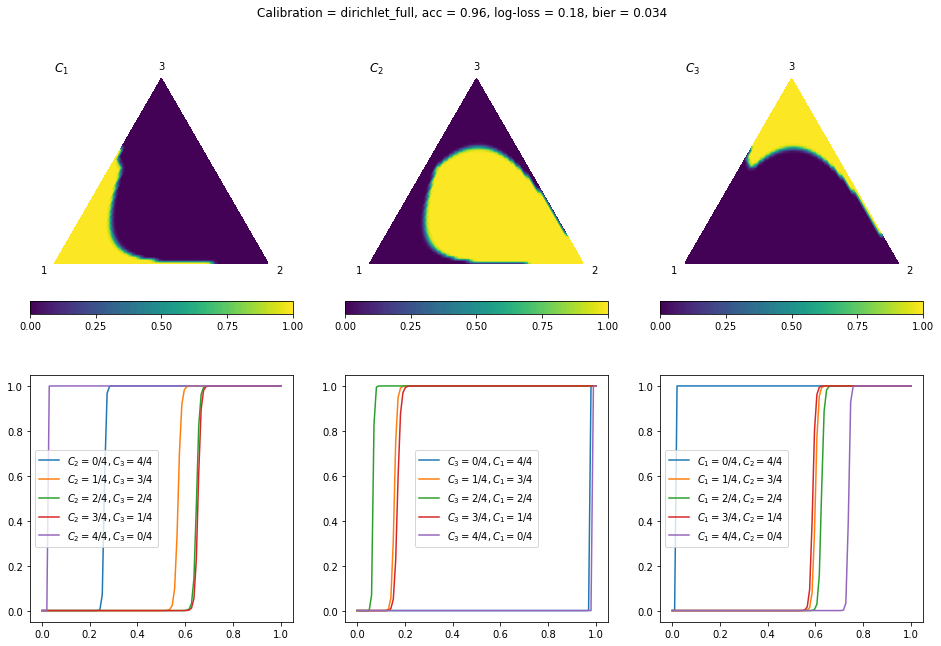

Calibrator DirichletCalibrator(matrix_type='full')
Coefficients are
[[ 55.04585171  -4.5450599  -62.52829694]
 [ 19.05692715  20.89476856 -49.21281319]]
Intercepts are
[-7.8012031  43.79317118]


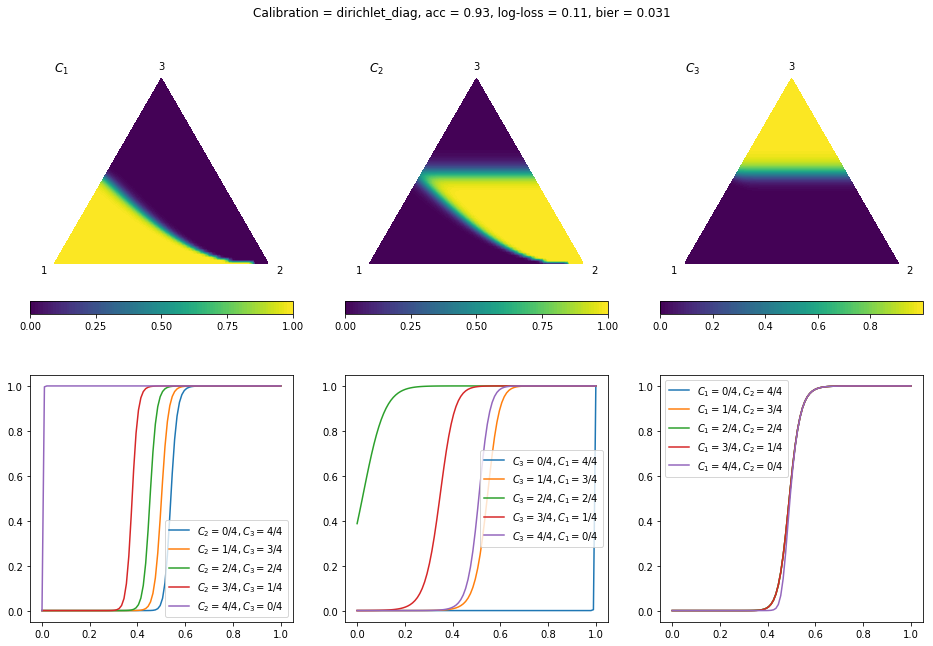

Calibrator DirichletCalibrator(matrix_type='diagonal')
Coefficients are
[[ 25.74417126   0.         -29.10034392]
 [  0.           0.         -20.84256417]]
Intercepts are
[ -5.12520029 -14.84740758]


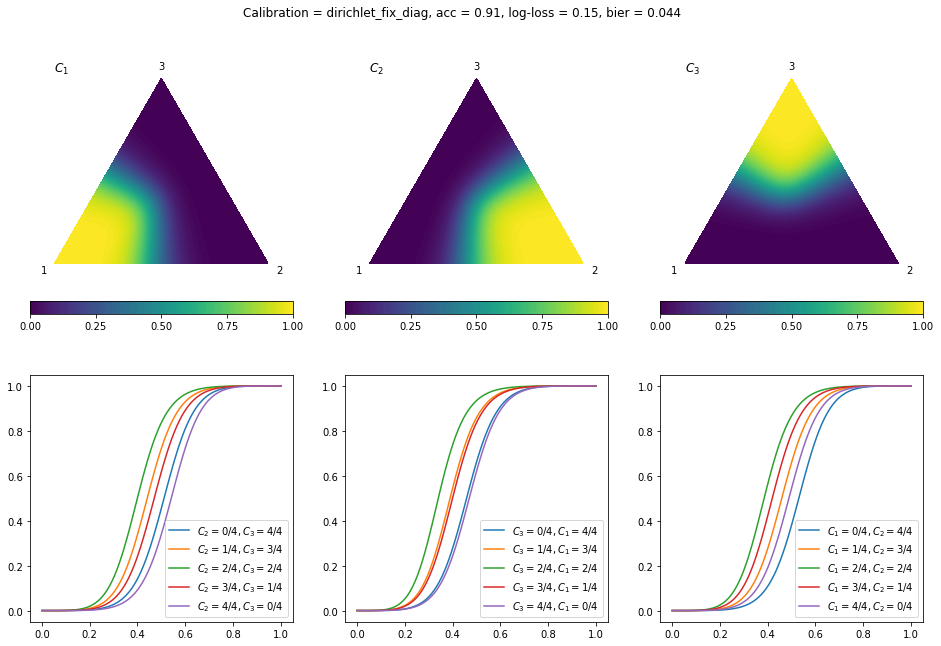

Calibrator DirichletCalibrator(matrix_type='fixed_diagonal')
Coefficients are
[[ 4.00871356  0.         -4.00871356]
 [ 0.          4.00871356 -4.00871356]]
Intercepts are
[-0.1789614   0.48638356]


In [16]:
for method in methods:
    calibrator = cl[method][0].calibrator
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Calibration = {}, acc = {:.2}, log-loss = {:.2}, bier = {:.2}'.format(
        method, accs[method], losses[method], briers[method]))
    for i, c in enumerate(['C1', 'C2', 'C3']):
        ax = fig.add_subplot(2, 3, i+1)

        ax.set_title('$C_{}$'.format(i+1), loc='left')

        function = lambda x: calibrator.predict_proba(x.reshape(1,-1))[0][i]
        draw_func_contours(function, labels=dataset.names, fig=fig, ax=ax, nlevels=nlevels, subdiv=subdiv)
        
        ax2 = fig.add_subplot(2, 3, 3+i+1)
        lines = get_converging_lines(num_lines=5, mesh_precision=nlevels, class_index=i)
        plot_converging_lines_pvalues(function, lines, i, ax2)
        
                
    plt.show()
    print('Calibrator {}'.format(calibrator))
    if hasattr(calibrator, 'coef_'):
        print('Coefficients are\n{}'.format(calibrator.coef_))
    if hasattr(calibrator, 'intercept_'):
        print('Intercepts are\n{}'.format(calibrator.intercept_))

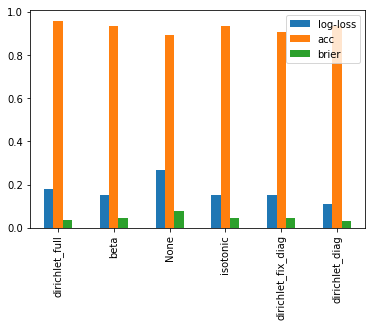

In [17]:
import pandas as pd
import numpy as np
results = {'log-loss': losses,
           'acc': accs,
           'brier': briers}
values = np.zeros((len(next(iter(results.values()))), len(results)))
for i, key_i in enumerate(next(iter(results.values())).keys()):
    for j, key_j in enumerate(results.keys()):
        values[i,j] = results[key_j][key_i]
df = pd.DataFrame(values, index=next(iter(results.values())).keys(), columns=results.keys())
df.plot(kind='bar')